In [1]:
!rm -rf /kaggle/working/*

!pip install split-folders
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import os
import tensorflow as tf

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from typing import List

tf.config.list_physical_devices('GPU')

2024-05-28 14:45:45.045278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 14:45:45.045414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 14:45:45.167214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import splitfolders
import shutil

In [4]:
def recursive_rmdir(folder):
    for item in os.listdir(folder):
        item_path = os.path.join(folder, item)
        
        if os.path.isdir(item_path):
            recursive_rmdir(item_path)
            os.rmdir(item_path)
        else:
            os.remove(item_path)
            

def organize_dataset(source_folder, destination_folder):    
    if os.path.exists(destination_folder):
        recursive_rmdir(destination_folder)
    
    # Discover all classes
    classes = set()
    for subfolder in os.listdir(source_folder):
        current_folder = os.path.join(source_folder, subfolder)
        discovered_classes = os.listdir(current_folder)
        classes = classes.union(discovered_classes)
    classes = list(classes)
    classes.sort()

    # Create a folder for each class
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    
    for _class in classes:
        class_directory = os.path.join(destination_folder, _class)
        os.mkdir(class_directory)
    
    for subfolder in os.listdir(source_folder):
        current_path = os.path.join(source_folder, subfolder)
        for class_folder in os.listdir(current_path):
            current_path = os.path.join(source_folder, subfolder, class_folder)
            for file in os.listdir(current_path):
                
                file_source_path = os.path.join(
                    source_folder,
                    subfolder,
                    class_folder,
                    file
                )
                
                file_destination_path = os.path.join(
                    destination_folder,
                    class_folder,
                    file
                )
                
                shutil.copy2(
                    file_source_path,
                    file_destination_path,
                )

    return classes

In [5]:
def train_test_validation_split(
    source: str,
    destination: str,
    seed: int | None = None
):
    if seed is None:
        seed = np.random.randint(999999)
    print(f"Dataset's split seed is {seed}")

    if not os.path.isdir(destination):
        splitfolders.ratio(source, output=destination,
            seed=seed, ratio=(.6, .2, .2), move=False)

In [6]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 4.4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.show()

In [7]:
def get_true_and_predicted_labels(model, dataset):
    y_true = []
    y_pred = []
    
    for X_batch, y_batch in dataset:
        y_batch_pred = np.argmax(model.predict(X_batch, verbose=0), axis=1)
        
        y_true.append(y_batch)
        y_pred.append(y_batch_pred)
    
    y_true = [y_batch.numpy() for y_batch in y_true]
    
    return np.concatenate(y_true), np.concatenate(y_pred)

In [8]:
classes = organize_dataset(
    os.path.join("/", "kaggle", "input", "chest-xray-pneumoniacovid19tuberculosis"),
    os.path.join("/", "kaggle", "working", "temp"),
)
train_test_validation_split(
    os.path.join("/", "kaggle", "working", "temp"),
    os.path.join("/", "kaggle", "working", "dataset"),
    seed=892471
)

print("Found classes:", classes)

Dataset's split seed is 892471


Copying files: 7132 files [00:02, 2835.35 files/s]

Found classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [9]:
print("\n[ TRAIN DATASET ]")
train_dataset = train_set = tf.keras.utils.image_dataset_from_directory(
    os.path.join("/", "kaggle", "working", "dataset", "train"),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear',
)

print("\n[ VALIDATION DATASET ]")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join("/", "kaggle", "working", "dataset", "val"),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear',
)

print("\n[ TEST DATASET ]")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join("/", "kaggle", "working", "dataset", "test"),
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    interpolation='bilinear',
)


[ TRAIN DATASET ]
Found 4277 files belonging to 4 classes.

[ VALIDATION DATASET ]
Found 1425 files belonging to 4 classes.

[ TEST DATASET ]
Found 1430 files belonging to 4 classes.


In [10]:
vgg_16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="max",
)

for layer in vgg_16.layers:
    layer.freeze = True

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005, name="optimizer")
loss = tf.keras.losses.SparseCategoricalCrossentropy(name="loss")

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    vgg_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dense(4096, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax"),
], name="model")

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"],
)
model.build((None, 224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
model_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=9999,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            model.name + '.keras',
            monitor='val_accuracy',
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq="epoch",
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=2,
            verbose=1,
            mode='auto',
        ),
    ],
)

# Save history
dataframe = pd.DataFrame(model_history.history)
dataframe.to_csv("history.csv", index_label="model_name", header=True, index=True)

Epoch 1/9999


I0000 00:00:1716907640.487397      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.8433
Epoch 1: val_accuracy improved from -inf to 0.93263, saving model to model.keras
134/134 [==============================] - 63s 336ms/step - loss: 0.5244 - accuracy: 0.8433 - val_loss: 12.9828 - val_accuracy: 0.9326
Epoch 2/9999
134/134 [==============================] - ETA: 0s - loss: 1.1560 - accuracy: 0.9472
Epoch 2: val_accuracy improved from 0.93263 to 0.95228, saving model to model.keras
134/134 [==============================] - 38s 273ms/step - loss: 1.1560 - accuracy: 0.9472 - val_loss: 22.0994 - val_accuracy: 0.9523
Epoch 3/9999
134/134 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.9710
Epoch 3: val_accuracy did not improve from 0.95228
134/134 [==============================] - 36s 259ms/step - loss: 0.5058 - accuracy: 0.9710 - val_loss: 21.5831 - val_accuracy: 0.9432
Epoch 4/9999
134/134 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.9818


# Testando o melhor modelo

               precision    recall  f1-score   support

      COVID19       0.98      0.92      0.95       116
       NORMAL       0.97      0.90      0.93       318
    PNEUMONIA       0.96      0.99      0.98       856
TURBERCULOSIS       0.94      0.98      0.96       140

     accuracy                           0.96      1430
    macro avg       0.96      0.95      0.96      1430
 weighted avg       0.96      0.96      0.96      1430



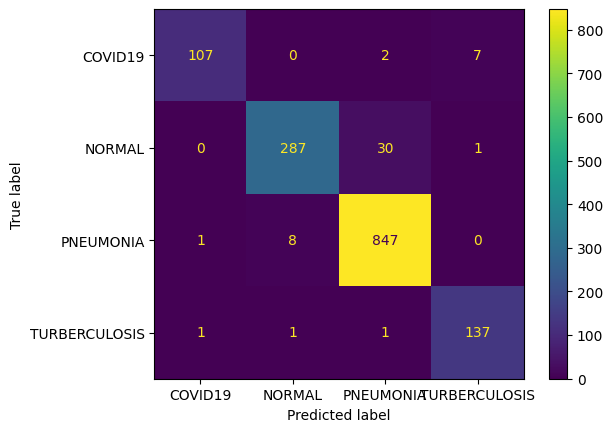

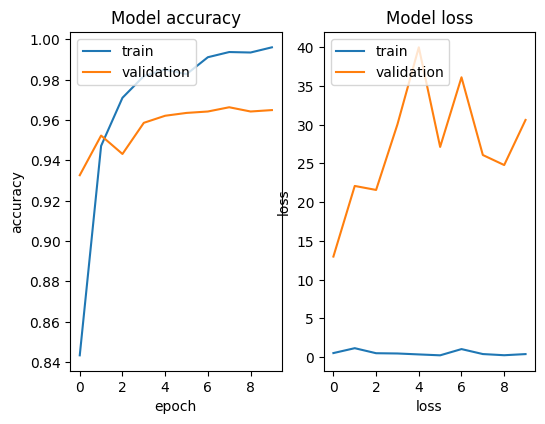

In [12]:
best_model = tf.keras.saving.load_model("model.keras")
y_true, y_pred = get_true_and_predicted_labels(model, test_dataset)

model_accuracy = accuracy_score(y_true, y_pred)

# Saving confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=classes
)
plt.savefig("confusion_matrix.png")

print(classification_report(y_true, y_pred, target_names=classes))

plot_model_history(model_history)